# House Price Prediction from Begginer's

In [1]:
# base
# import tensorflow as tf
# import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import skew

# настройка для корректной настройки pipeline
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor


# tunning hyperparamters model
import optuna

In [2]:
#  указываем, что бы отображались все столбцы и при необходимости 100 строк.
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)    

In [3]:
# Загружаем датасеты
test = pd.read_csv("./data/test.csv")
train = pd.read_csv("./data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")


print (f"Полный дата сет в виде {train.shape}")

Полный дата сет в виде (1460, 81)


In [4]:
print("Full train dataset shape is {}".format(train.shape))

Full train dataset shape is (1460, 81)


In [5]:
# Предварительный просмотр
train.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [6]:
# Проверяем наличие пропуско и тип 
pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes}).T   

Id MSSubClass MSZoning LotFrontage LotArea  Street   Alley  \
NaN_count      0          0        0         259       0       0    1369   
data_type  int64      int64   object     float64   int64  object  object   

          LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
NaN_count        0           0         0         0         0            0   
data_type   object      object    object    object    object       object   

          Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond  \
NaN_count          0          0        0          0           0           0   
data_type     object     object   object     object       int64       int64   

          YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
NaN_count         0            0         0        0           0           0   
data_type     int64        int64    object   object      object      object   

          MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
NaN_count        872          8         0         0          0       37   
data_type     object    float64    object    object     object   object   

          BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2  \
NaN_count       37           38           37          0           38   
data_type   object       object       object      int64       object   

          BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir  \
NaN_count          0         0           0       0         0          0   
data_type      int64     int64       int64  object    object     object   

          Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath  \
NaN_count          1        0        0            0         0            0   
data_type     object    int64    int64        int64     int64        int64   

          BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr  \
NaN_count            0        0        0            0            0   
data_type        int64    int64    int64        int64        int64   

          KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
NaN_count           0            0          0          0         690   
data_type      object        int64     object      int64      object   

          GarageType GarageYrBlt GarageFinish GarageCars GarageArea  \
NaN_count         81          81           81          0          0   
data_type     object     float64       object      int64      int64   

          GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF  \
NaN_count         81         81          0          0           0   
data_type     object     object     object      int64       int64   

          EnclosedPorch 3SsnPorch ScreenPorch PoolArea  PoolQC   Fence  \
NaN_count             0         0           0        0    1453    1179   
data_type         int64     int64       int64    int64  object  object   

          MiscFeature MiscVal MoSold YrSold SaleType SaleCondition SalePrice  
NaN_count        1406       0      0      0        0             0         0  
data_type      object   int64  int64  int64   object        object     int64

In [7]:
# смотрим количество пропущенных значений 
temp_df = pd.DataFrame({
    'Missing_Values': train.isna().sum(),
    'Missing_Values_Percent': (train.isna().mean() * 100)
}).sort_values('Missing_Values_Percent', ascending=False)

print(temp_df)

               Missing_Values  Missing_Values_Percent
PoolQC                   1453               99.520548
MiscFeature              1406               96.301370
Alley                    1369               93.767123
Fence                    1179               80.753425
MasVnrType                872               59.726027
FireplaceQu               690               47.260274
LotFrontage               259               17.739726
GarageQual                 81                5.547945
GarageFinish               81                5.547945
GarageType                 81                5.547945
GarageYrBlt                81                5.547945
GarageCond                 81                5.547945
BsmtFinType2               38                2.602740
BsmtExposure               38                2.602740
BsmtCond                   37                2.534247
BsmtQual                   37                2.534247
BsmtFinType1               37                2.534247
MasVnrArea                  

In [8]:
dataset_df = train.drop("Id", axis=1)

In [9]:
dataset_df.head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   
5          50       RL         85.0    14115   Pave   NaN      IR1   
6          20       RL         75.0    10084   Pave   NaN      Reg   
7          60       RL          NaN    10382   Pave   NaN      IR1   
8          50       RM         51.0     6120   Pave   NaN      Reg   
9         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd        NaN   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng        NaN   
9          1950     Gable  CompShg     MetalSd     MetalSd        NaN   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9         0.0        TA        TA     BrkTil       T

In [10]:
dataset_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [11]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [12]:
print(dataset_df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [13]:
plt.figure(figsize=(9,8))

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

/tmp/ipykernel_10197/3479937374.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df["SalePrice"], color="b", bins=1000, hist_kws={"alpha":0.5})


<Axes: xlabel='SalePrice', ylabel='Density'>

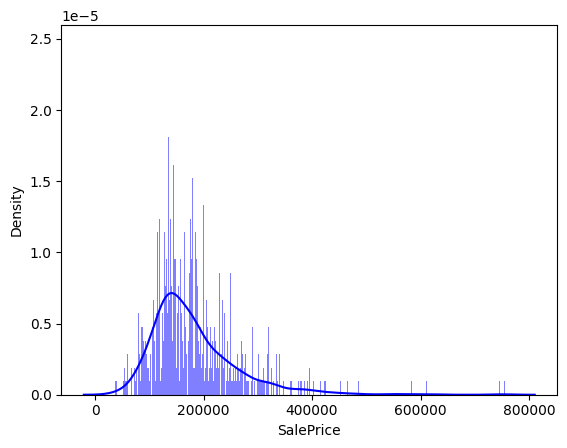

In [14]:
sns.distplot(dataset_df["SalePrice"], color="b", bins=1000, hist_kws={"alpha":0.5})

In [15]:
# Делим на категориальные и числовые признаки
df_num = dataset_df.select_dtypes(include = ["float64", "int64"])
df_cat = dataset_df.select_dtypes(include='object')

## Проводим анализ числовых данных

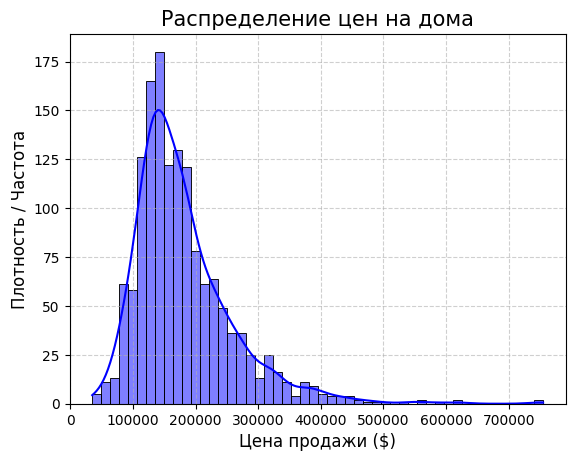

In [16]:
# Добавляем подписи
sns.histplot(df_num["SalePrice"], kde=True, color="b", bins=50)
plt.title("Распределение цен на дома", fontsize=15)
plt.xlabel("Цена продажи ($)", fontsize=12)
plt.ylabel("Плотность / Частота", fontsize=12)

# Включаем сетку, чтобы лучше видеть масштаб
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Наблюдаем правоскошенное распределение и несколько дорогих квартир, которые вытягивают график. Так же видим выбросы. В целом наблюдаем типичную картину для цен в недвижимости.
Поскольку из-за шума и выбросов в регрессии модель может быть переобучена, необходимо применить функцию потерь(loss), чтобы ослабить влияние выбросов.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

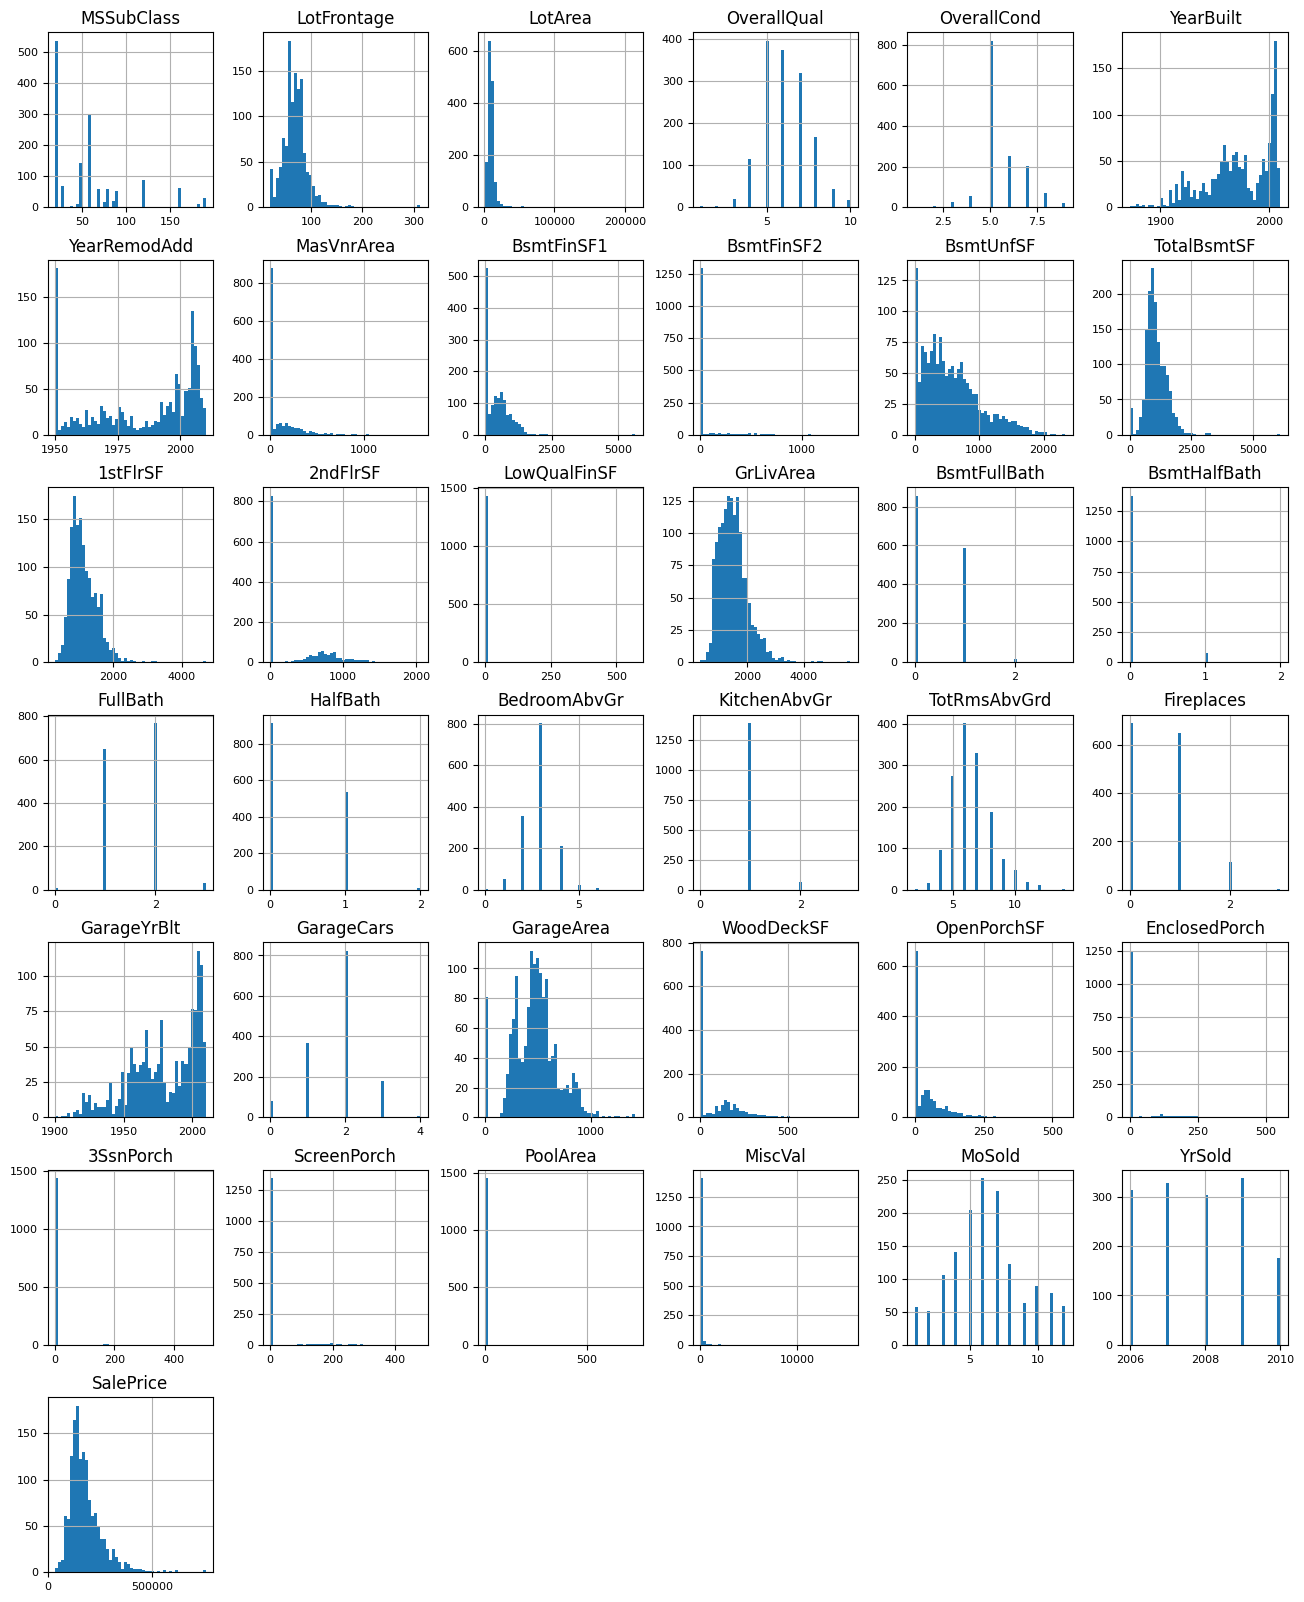

In [17]:
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

Первичный анализ соотношения параметров к количеству. Графики неудобно читаемы, решил объединить в диапазоны ниже.

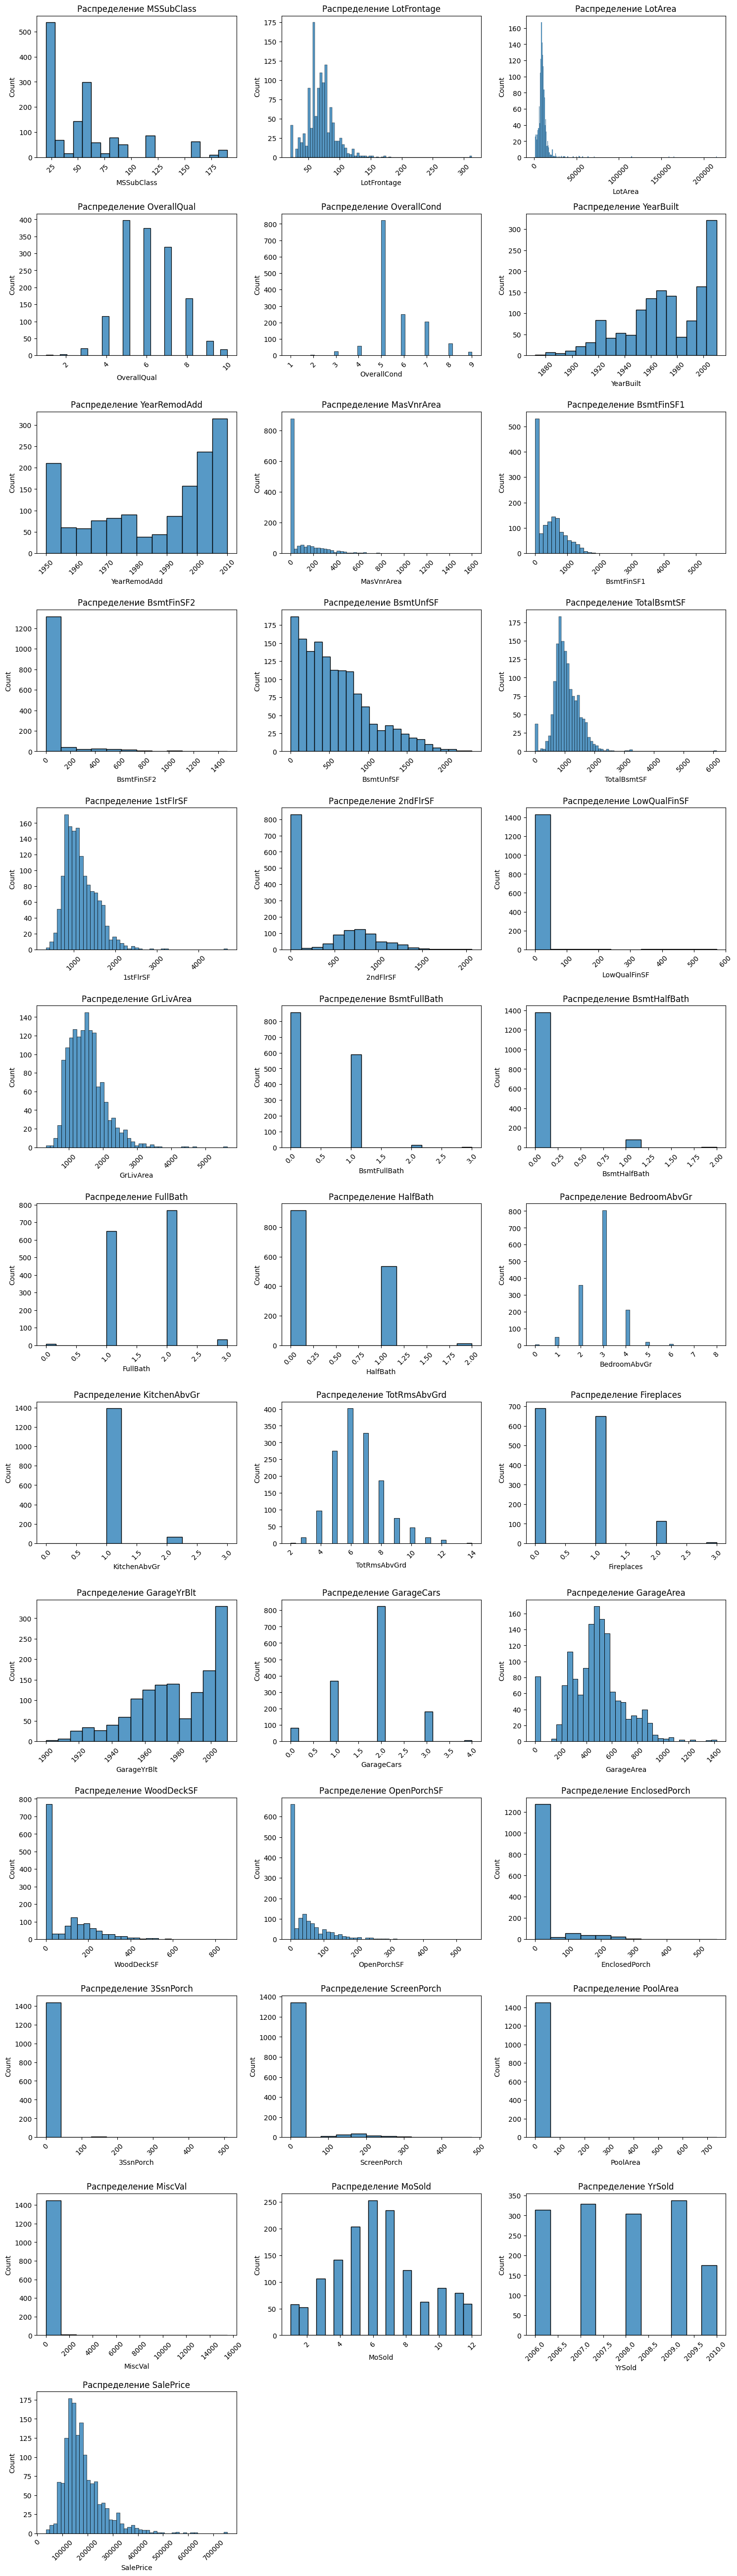

In [18]:
df_num = dataset_df.select_dtypes(include = ["float64", "int64"])
n_cols = 3
n_rows = (len(df_num) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_num):
    sns.histplot(x=dataset_df[col], ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Убираем пустые графики, если колонок меньше чем ячеек
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**MSSubClass: Идентифицирует тип жилья, участвующего в продаже.**

20	
1-этажные дома 1946 года и новее 

30	
1-этажные дома 1945 года и старше 

40	
1-этажные дома с жилой мансардой (все возрасты) 

45	
1.5-этажные дома — недостроенные (все возрасты) 

50	
1.5-этажные дома — достроенные (все возрасты) 

60	
2-этажные дома 1946 года и новее 

70	
2-этажные дома 1945 года и старше 

75	
2.5-этажные дома (все возрасты) 

80	
Расщепленный (split) или многоуровневый уровень 

85	
Расщепленный фойе (split foyer) 

90	
Дуплекс (все стили и возрасты) 

120	
1-этажный PUD (плановая застройка) 1946+ 

150	
1.5-этажный PUD (все возрасты) 

160	
2-этажный PUD 1946+ 

180	
PUD многоуровневый (включая split level/foyer) 

190	
Конверсия на 2 семьи (все стили и возрасты)

Всплески построек 1945 года и 1950 и 1960 годов. Не сильно информативно, но скорее всего будет зависимость к постройкам

**LotFrontage: Линейные футы фасада, примыкающего к улице.** Длинный хвост значение за 150 футов. Нужно логарифмировать признак 

**LotArea: Размер участка в квадратных футах.** Нужно логарифмировать признак 

**OverallQual: Оценивает общие материалы и отделку дома.** Существенное влияние на оценку стоимости. Рассмотреть как колинеарный параметр

**OverallCond: Оценивает общее состояние дома.**

**OverallQual/ OverallCond нужно будет расмотреть как feature**

10	
Очень превосходно (Very Excellent) 

9	
Превосходно (Excellent) 

8	
Очень хорошо (Very Good) 

7	
Хорошо (Good) 

6	
Выше среднего (Above Average) 

5	
Средне (Average) 

4	
Ниже среднего (Below Average) 

3	
Посредственно (Fair) 

2	
Плохо (Poor) 

1	
Очень плохо (Very Poor)

**YearBuilt: Дата первоначальной постройки.** Значение интересно для оценки

**YearRemodAdd: Дата реконструкции (совпадает с датой постройки, если реконструкции не было).** Сильная зависимость на цену

**MasVnrArea: Площадь облицовки в квадратных футах.** Необходимо лоагрфимировать. Слишком длинный хвост на графике

**BsmtFinSF1: Площадь отделки 1-го типа в квадратных футах.**Необходимо лоагрфимировать. Слишком длинный хвост на графике

**BsmtFinSF2: Площадь отделки 2-го типа в квадратных футах.**Необходимо лоагрфимировать. Слишком длинный хвост на графике.

**BsmtUnfSF: Площадь неосвоенного (чернового) подвала в кв. футах.**

**TotalBsmtSF: Общая площадь подвала в квадратных футах.** Необходимо лоагрфимировать. Слишком длинный хвост на графике

**1stFlrSF: Площадь первого этажа в квадратных футах.** Необходимо лоагрфимировать. Слишком длинный хвост на графике

**2ndFlrSF: Площадь второго этажа в квадратных футах.**Необходимо лоагрфимировать. Слишком длинный хвост на графике

**LowQualFinSF: Площадь отделки низкого качества (на всех этажах).** Необходимо лоагрфимировать. Слишком длинный хвост на графике

**GrLivArea: Жилая площадь над уровнем земли в квадратных футах.** Рассмотреть как колинеарный параметр. Существенное влияние на стоимость

**BsmtFullBath: Полноценные ванные комнаты в подвале.**

**BsmtHalfBath: Санузлы (половинные ванны) в подвале.**

**FullBath: Полноценные ванные комнаты над уровнем земли.**

**HalfBath: Санузлы над уровнем земли.**




**TotRmsAbvGrd: Общее количество комнат над уровнем земли (без ванных).**


**Fireplaces: Количество каминов.**

**GarageYrBlt: Год постройки гаража.** добавьте  признак HasGarage, где 0 — нет гаража, 1 — есть.

**GarageCars: Вместимость гаража (количество машин).**

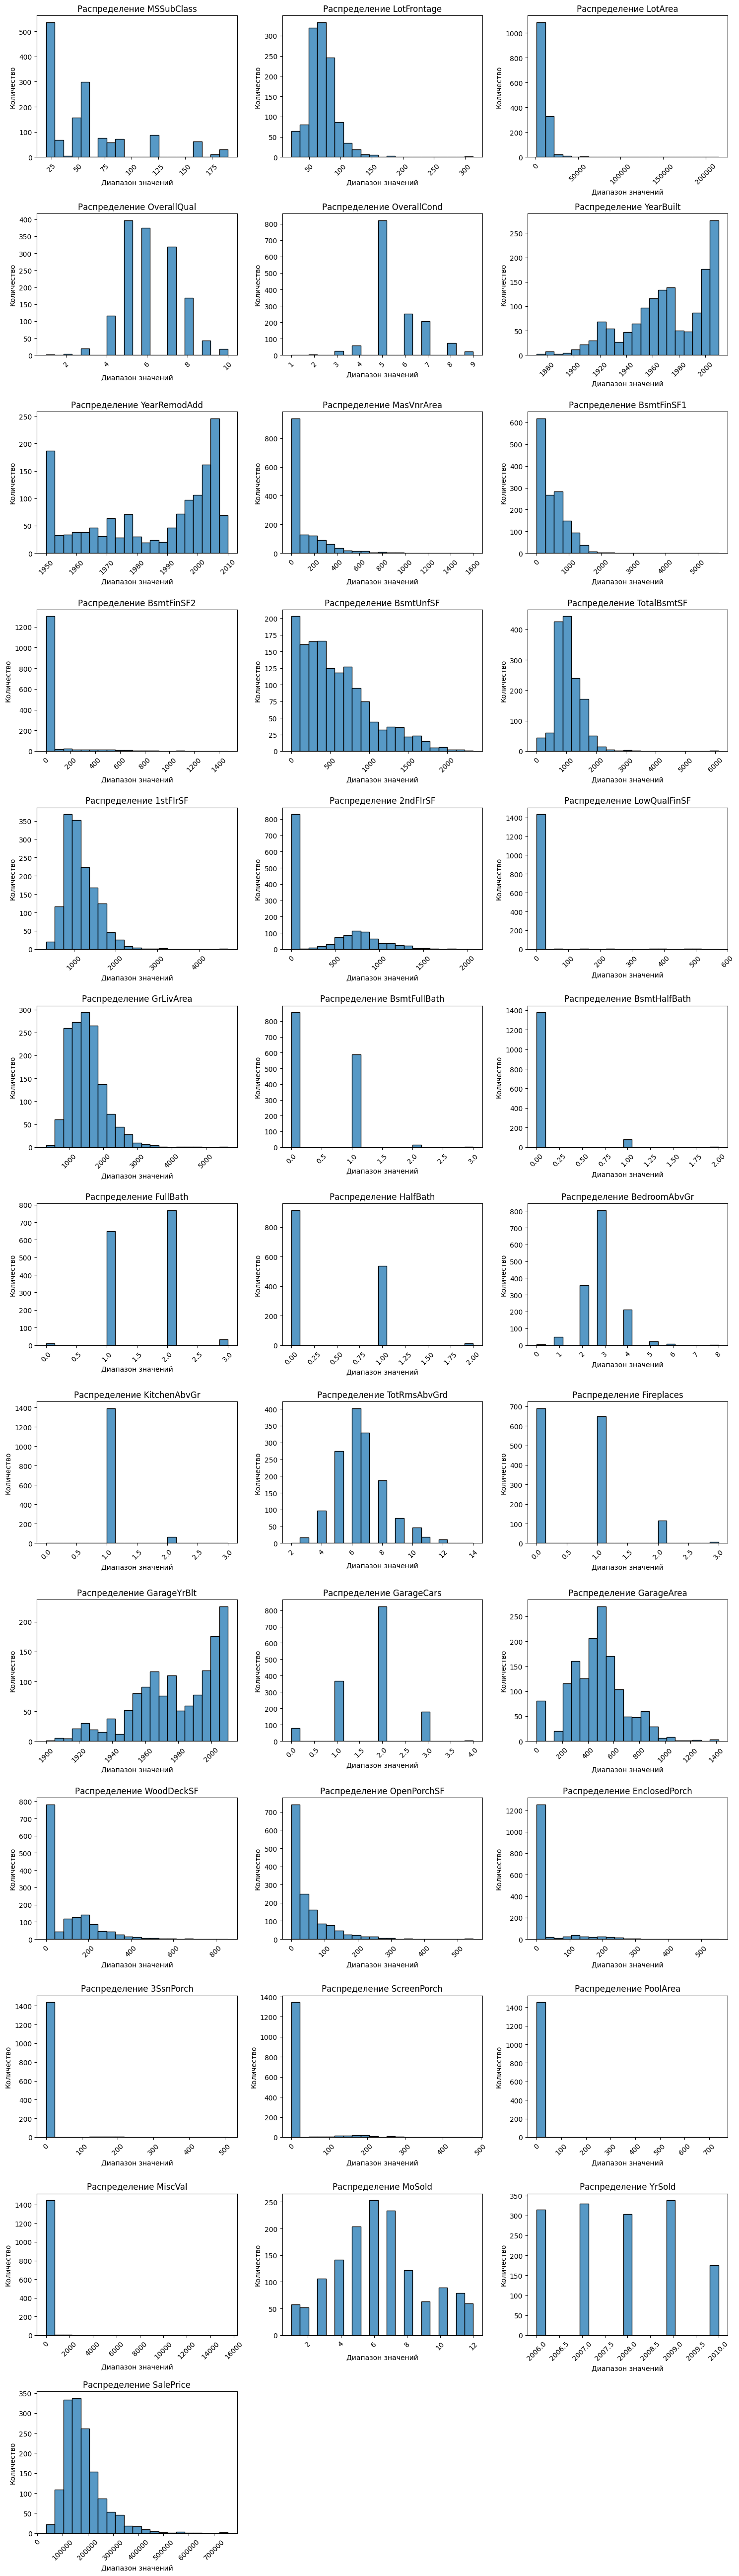

In [19]:
# Выбираем только числовые колонки
df_num = dataset_df.select_dtypes(include = ["float64", "int64"])

n_cols = 3
n_rows = (df_num.shape[1] - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    # Используем histplot вместо countplot
    # bins=21 создаст максимум 21 столбик
    # kde=False убирает линию оценки плотности
    sns.histplot(df_num[col], bins=21, ax=axes[i], kde=False)
    
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('Диапазон значений')
    axes[i].set_ylabel('Количество')
    
    # Поворот меток, если они будут длинными
    axes[i].tick_params(axis='x', rotation=45)

# Удаляем пустые подобъекты axes, если количество колонок не кратно n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
len(df_num)

1460

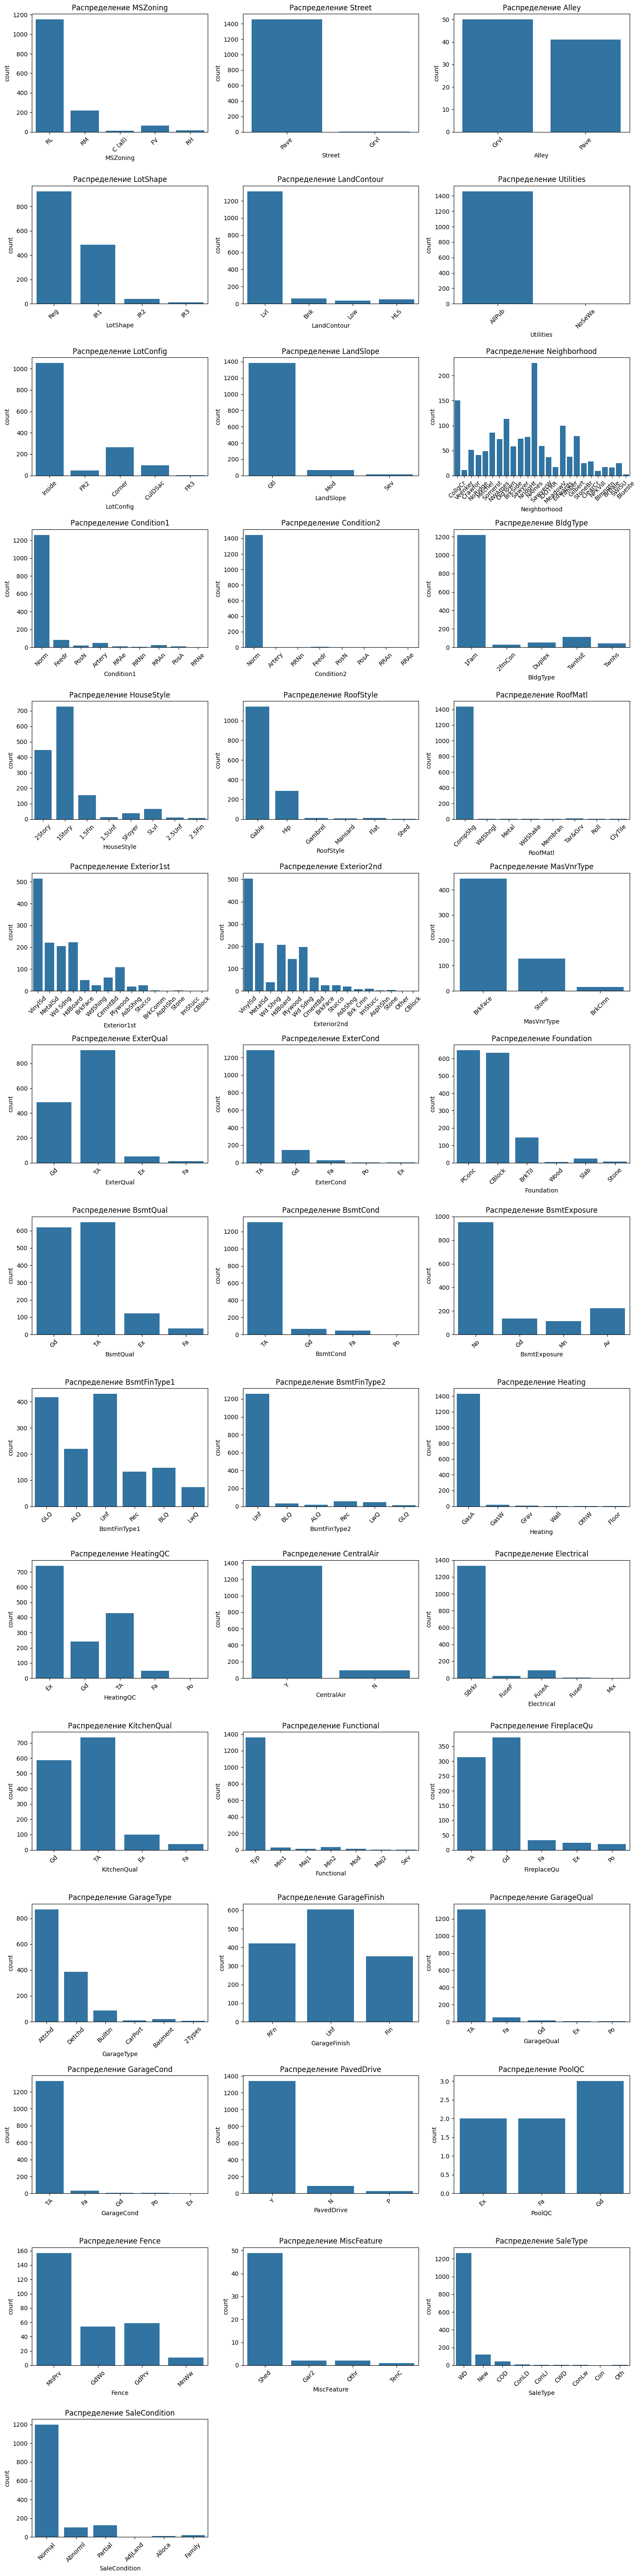

In [21]:
cols = dataset_df.select_dtypes(include=['object']).columns
n_cols = 3
n_rows = (len(cols) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.countplot(x=dataset_df[col], ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Убираем пустые графики, если колонок меньше чем ячеек
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

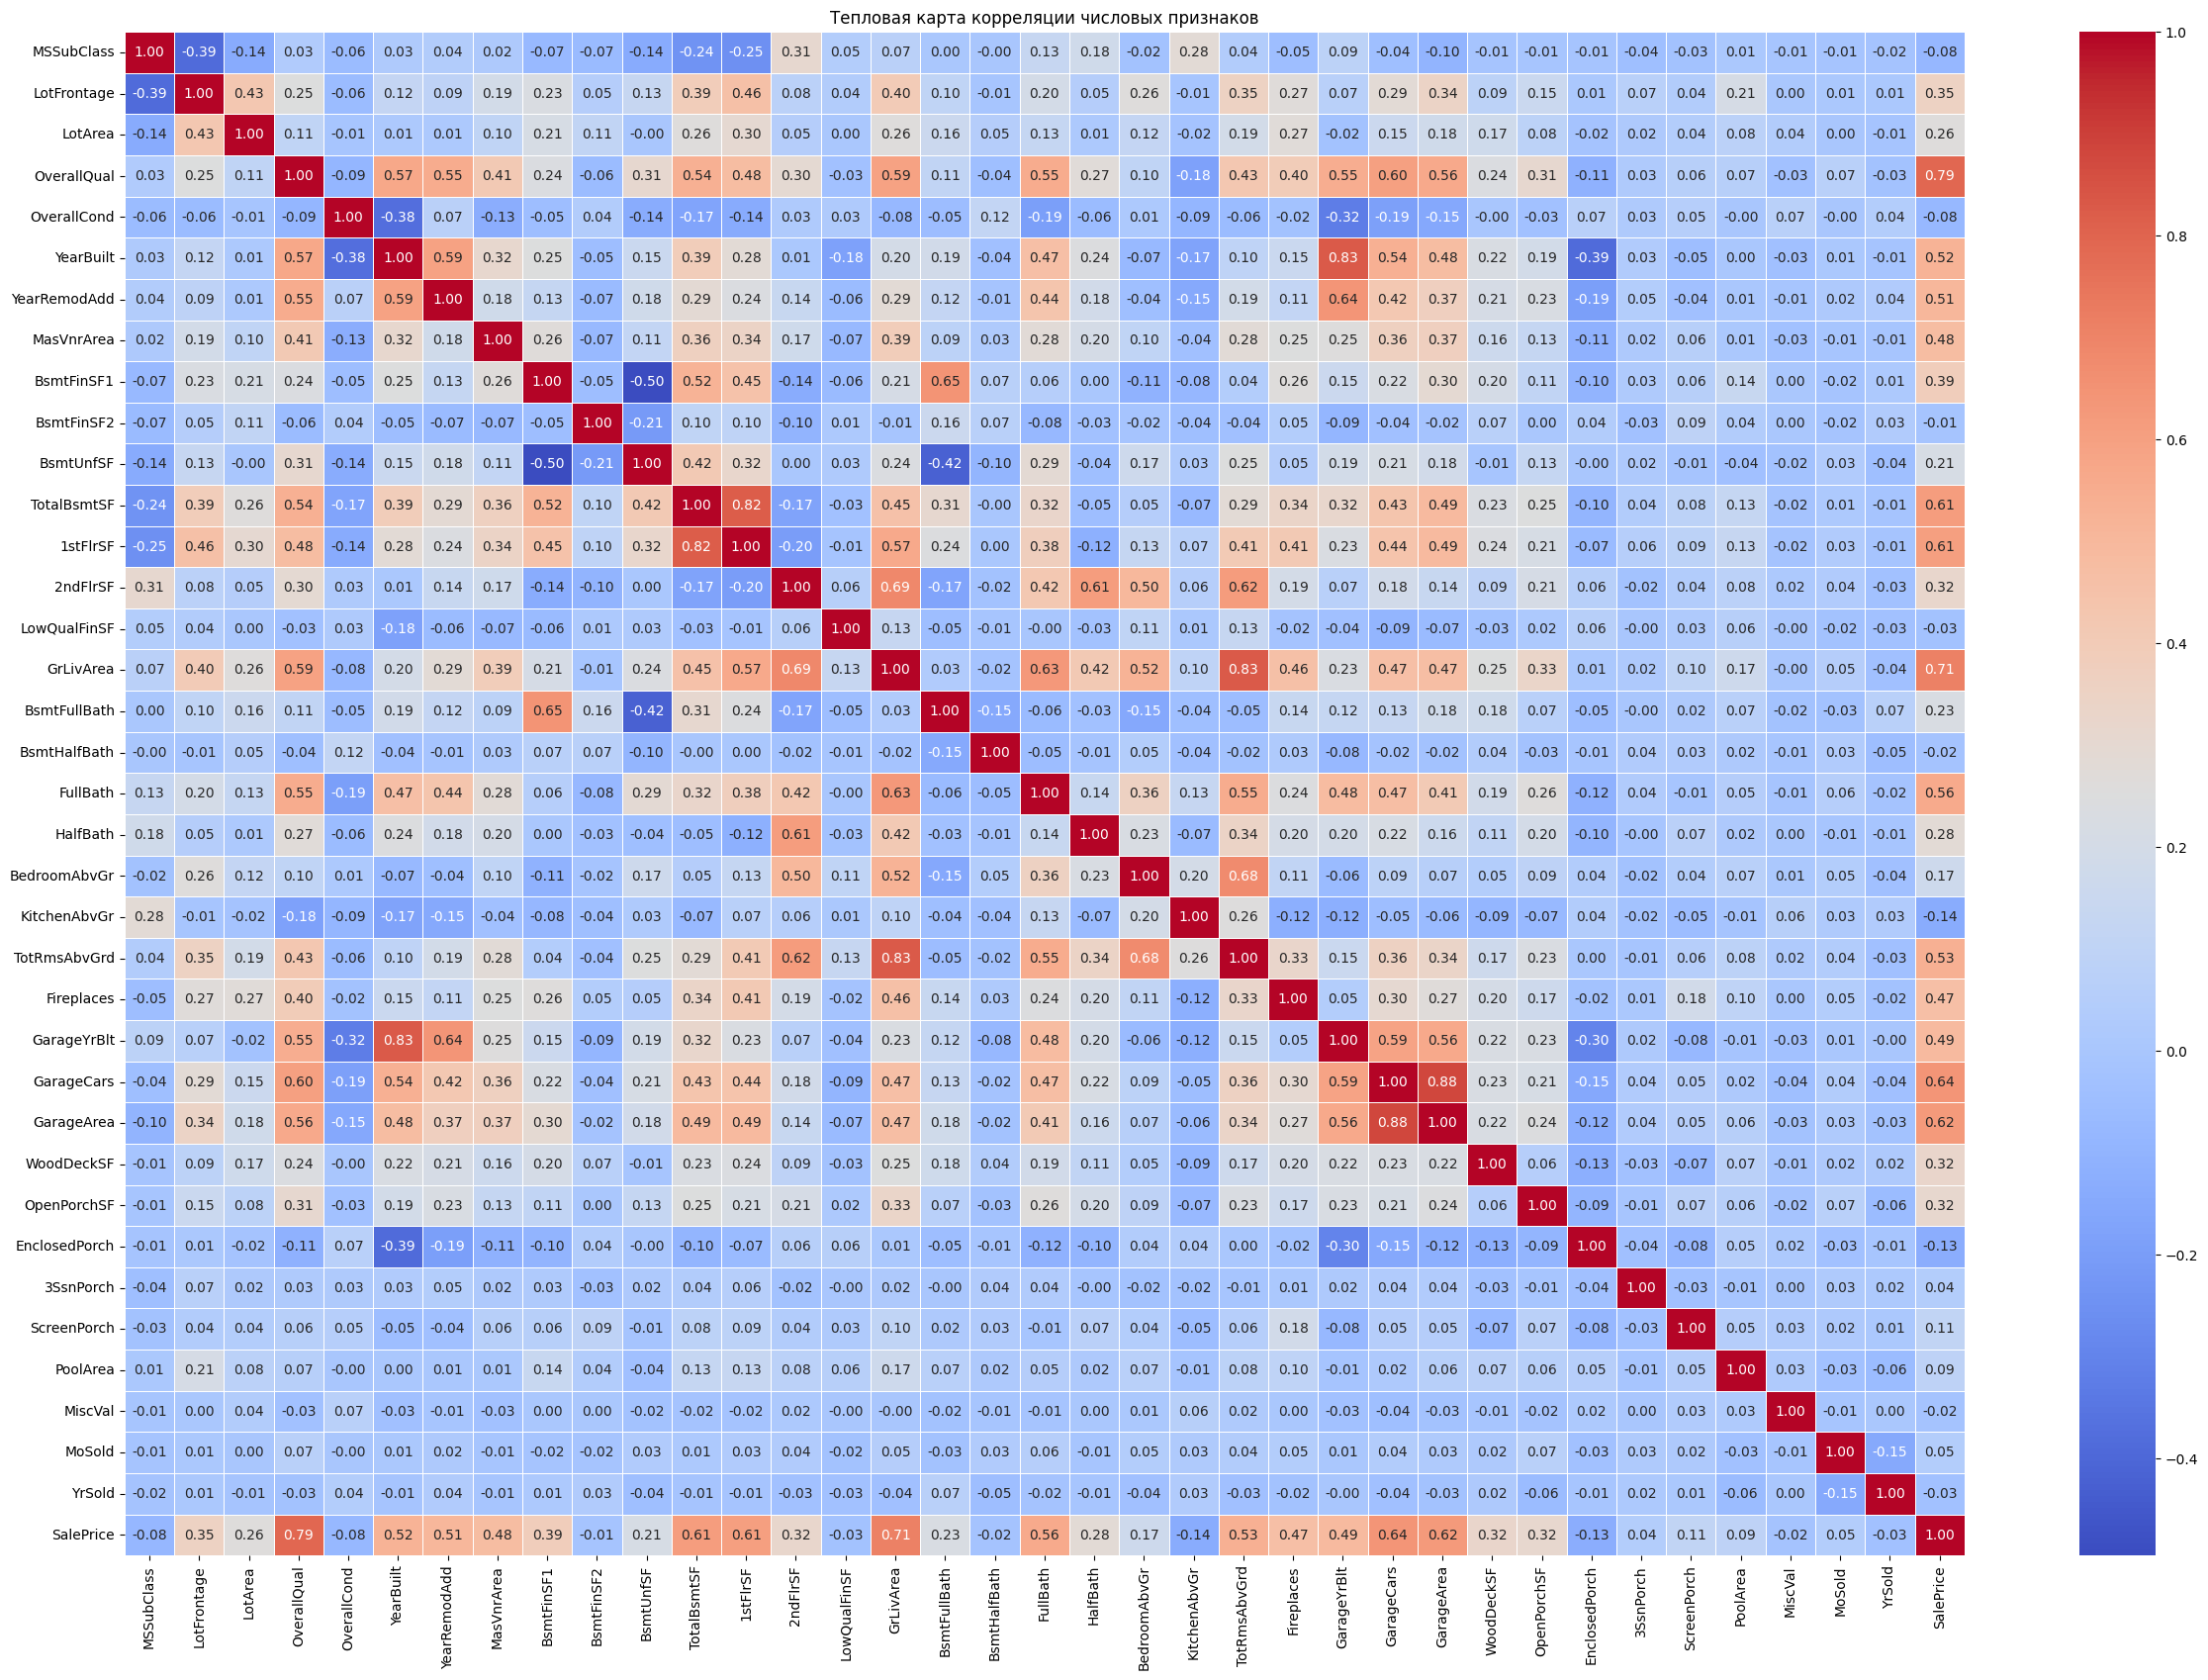

In [22]:
# Смотрим с какими признаками коррелирует целевая переменная SalePrice
corr_matrix = df_num.corr()

# Настройка размера полотна
plt.figure(figsize=(30,20))

# Строим heatmap
# cmap='coolwarm' наглядно показывает положительную (красный) и отрицательную (синий) корреляцию
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

plt.title('Тепловая карта корреляции числовых признаков')
plt.show()

In [23]:
corr = df_num.corr()
corr_with_target = corr["SalePrice"].sort_values(key=lambda x: abs(x), ascending=False)
corr_with_target

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

Наибольшую корреляцию мы наблюдаем со следующими признаками:
                                                            OverallQual (0,82)
                                                            GrLivArea (0,70)
                                                            YearBuilt / YearRemodAdd (0,58)
                                                            TotalBsmtSF (0,60)
                                                            1stFlrSF (0,60)
                                                            FullBath (0.60)
                                                            GarageCars / GarageArea (0,66)
Признаки с низкой корреляцией (менее 0.05):
                                            Id(-0,018)
                                            OverallCond(-0.037)
                                            BsmtFinSF2(0.0048)
                                            LowQualFinSF(-0.038)
                                            3SsnPorch(0.055)
                                            MiscVal(-0.02)

In [24]:
# Вычисляем асимметрию для всех числовых признаков
numeric_feats = dataset_df.select_dtypes(include=["float64", "int64"]).columns
skewed_feats = dataset_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Превращаем в DataFrame для удобства
skewness = pd.DataFrame({'Skew' :skewed_feats})

# Фильтруем признаки с высокой асимметрией (порог 0.75)
high_skew = skewness[abs(skewness['Skew']) > 0.75]

print(f"Найдено {len(high_skew)} признаков с высокой асимметрией:")
print(high_skew)

Найдено 22 признаков с высокой асимметрией:
                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
EnclosedPorch   3.086696
MasVnrArea      2.666326
OpenPorchSF     2.361912
LotFrontage     2.160866
SalePrice       1.880941
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
TotalBsmtSF     1.522688
MSSubClass      1.406210
1stFlrSF        1.375342
GrLivArea       1.365156
BsmtUnfSF       0.919323
2ndFlrSF        0.812194


In [25]:
df_num.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [26]:
df_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [27]:
df_num["LotFrontage"]=dataset_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) 
df_num["GarageYrBlt"] = df_num["GarageYrBlt"].fillna(0) 
df_num["MasVnrArea"] = df_num["MasVnrArea"].fillna(0) 
print(df_num[["LotFrontage", "GarageYrBlt", "MasVnrArea"]].isnull().sum()) 

LotFrontage    0
GarageYrBlt    0
MasVnrArea     0
dtype: int64


In [28]:
df_num["HasGarage"] = (df_num["GarageYrBlt"]>0).astype(int) 
df_num["SalePrice"] = np.log1p(df_num["SalePrice"]) 
skewed_features = high_skew.index 
df_num = df_num.drop(df_num[(df_num["GrLivArea"]>4000)].index)

In [29]:
df_num.corr()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.390953 -0.142192     0.032416    -0.059277   
LotFrontage     -0.390953     1.000000  0.307608     0.215803    -0.039789   
LotArea         -0.142192     0.307608  1.000000     0.088719    -0.002832   
OverallQual      0.032416     0.215803  0.088719     1.000000    -0.090692   
OverallCond     -0.059277    -0.039789 -0.002832    -0.090692     1.000000   
YearBuilt        0.027689     0.112557  0.006590     0.571712    -0.375691   
YearRemodAdd     0.040459     0.076068  0.006930     0.550971     0.074703   
MasVnrArea       0.023441     0.168014  0.080357     0.395336    -0.127621   
BsmtFinSF1      -0.075268     0.143383  0.173426     0.213079    -0.042542   
BsmtFinSF2      -0.065598     0.058972  0.114691    -0.057520     0.040015   
BsmtUnfSF       -0.140890     0.126690 -0.003774     0.310164    -0.137267   
TotalBsmtSF     -0.255441     0.308715  0.221940     0.532666    -0.176000   
1stFlrSF        -0.265001     0.380282  0.267644     0.462042    -0.145613   
2ndFlrSF         0.311294     0.048999  0.037277     0.279745     0.031297   
LowQualFinSF     0.046499     0.035211  0.005675    -0.029826     0.025406   
GrLivArea        0.077956     0.328693  0.231887     0.583519    -0.078567   
BsmtFullBath     0.003282     0.085071  0.147595     0.104092    -0.053107   
BsmtHalfBath    -0.002509     0.005720  0.047391    -0.047172     0.117207   
FullBath         0.132131     0.176080  0.117336     0.543791    -0.194167   
HalfBath         0.177476     0.040266  0.005981     0.267431    -0.059927   
BedroomAbvGr    -0.023627     0.251384  0.118960     0.096848     0.013249   
KitchenAbvGr     0.281783    -0.003018 -0.016565    -0.184281    -0.087204   
TotRmsAbvGrd     0.040247     0.312977  0.173629     0.415834    -0.055766   
Fireplaces      -0.046377     0.225574  0.259701     0.387425    -0.022277   
GarageYrBlt     -0.081066     0.106315  0.071511     0.289955    -0.006274   
GarageCars      -0.040490     0.284859  0.150977     0.598739    -0.185494   
GarageArea      -0.100145     0.315386  0.162183     0.554905    -0.150679   
WoodDeckSF      -0.012853     0.080110  0.167040     0.232819    -0.003063   
OpenPorchSF     -0.006687     0.110006  0.061679     0.297803    -0.029649   
EnclosedPorch   -0.011966     0.013423 -0.016108    -0.112407     0.070103   
3SsnPorch       -0.043802     0.069672  0.021505     0.031621     0.025419   
ScreenPorch     -0.025979     0.046951  0.045620     0.067732     0.054617   
PoolArea         0.007957     0.058299  0.033875     0.018121     0.008079   
MiscVal         -0.007666     0.006819  0.039192    -0.031068     0.068729   
MoSold          -0.013512     0.022029  0.007188     0.076414    -0.003135   
YrSold          -0.021330     0.007566 -0.013014    -0.024321     0.043755   
SalePrice       -0.075083     0.360796  0.258945     0.819240    -0.036843   
HasGarage       -0.085414     0.103680  0.073353     0.263002     0.009889   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass      0.027689      0.040459    0.023441   -0.075268   -0.065598   
LotFrontage     0.112557      0.076068    0.168014    0.143383    0.058972   
LotArea         0.006590      0.006930    0.080357    0.173426    0.114691   
OverallQual     0.571712      0.550971    0.395336    0.213079   -0.057520   
OverallCond    -0.375691      0.074703   -0.127621   -0.042542    0.040015   
YearBuilt       1.000000      0.591906    0.309923    0.248272   -0.048393   
YearRemodAdd    0.591906      1.000000    0.172959    0.121690   -0.067188   
MasVnrArea      0.309923      0.172959    1.000000    0.231890   -0.070339   
BsmtFinSF1      0.248272      0.121690    0.231890    1.000000   -0.048738   
BsmtFinSF2     -0.048393     -0.067188   -0.070339   -0.048738    1.000000   
BsmtUnfSF       0.148810      0.180972    0.111107   -0.526140   -0.209286   
TotalBsmtSF     0.399867      0.2948

/tmp/ipykernel_10197/2347776011.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=top_corr.values, y=top_corr.index, palette='viridis')


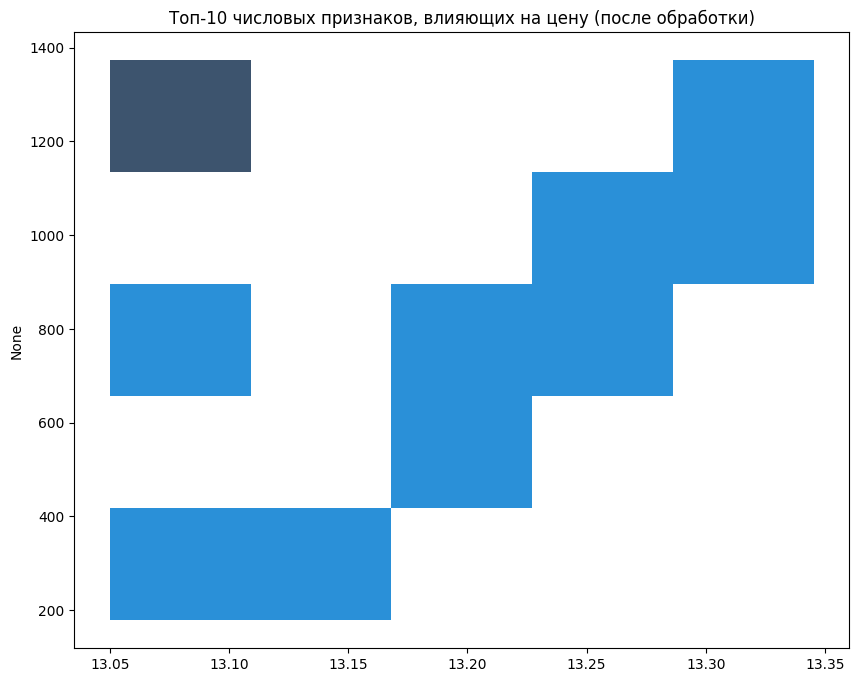

In [30]:
plt.figure(figsize=(10, 8))
top_corr = df_num['SalePrice'].sort_values(ascending=False).head(11)
sns.histplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Топ-10 числовых признаков, влияющих на цену (после обработки)')
plt.show()

/tmp/ipykernel_10197/3589949523.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_names, y=top_corr.values, palette='magma')


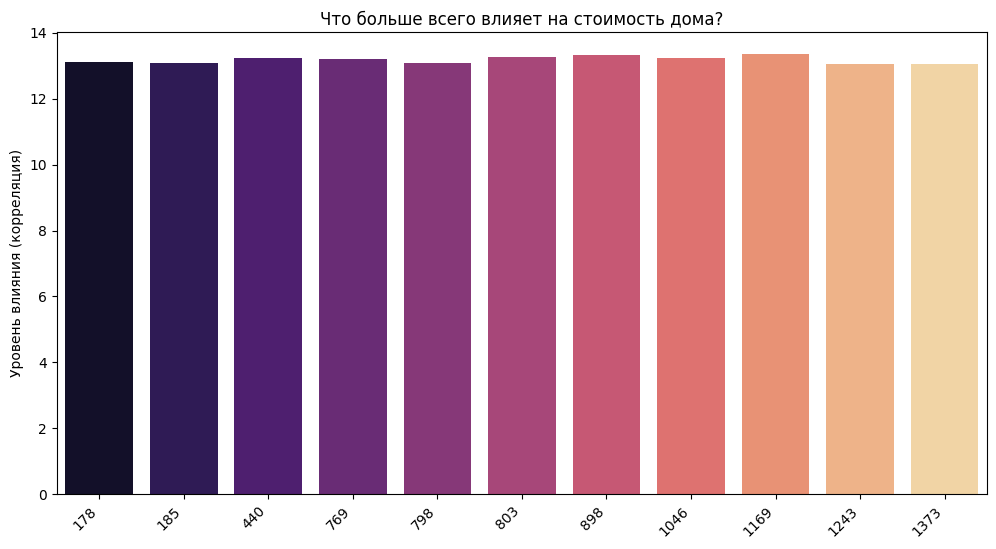

In [31]:
# 1. Готовим данные
top_corr = df_num['SalePrice'].sort_values(ascending=False).head(11)

# 2. Создаем список понятных названий
labels_map = {
    'SalePrice': 'Цена продажи',
    'OverallQual': 'Качество',
    'GrLivArea': 'Жилая площадь',
    'GarageCars': 'Гараж (мест)',
    'GarageArea': 'Пл. гаража',
    'TotalBsmtSF': 'Пл. подвала',
    '1stFlrSF': '1-й этаж',
    'FullBath': 'Ванные',
    'TotRmsAbvGrd': 'Комнат всего',
    'YearBuilt': 'Год постройки',
    'YearRemodAdd': 'Год реновации'
}
new_names = [labels_map.get(col, col) for col in top_corr.index]

# 3. Строим график
plt.figure(figsize=(12, 6))

# ПЕРЕДАЕМ: x - названия, y - числа
sns.barplot(x=new_names, y=top_corr.values, palette='magma')

plt.xticks(rotation=45, ha='right')
plt.title('Что больше всего влияет на стоимость дома?')
plt.ylabel('Уровень влияния (корреляция)')
plt.show()

/tmp/ipykernel_10197/1283617123.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_names, y=nice_labels, palette='magma')


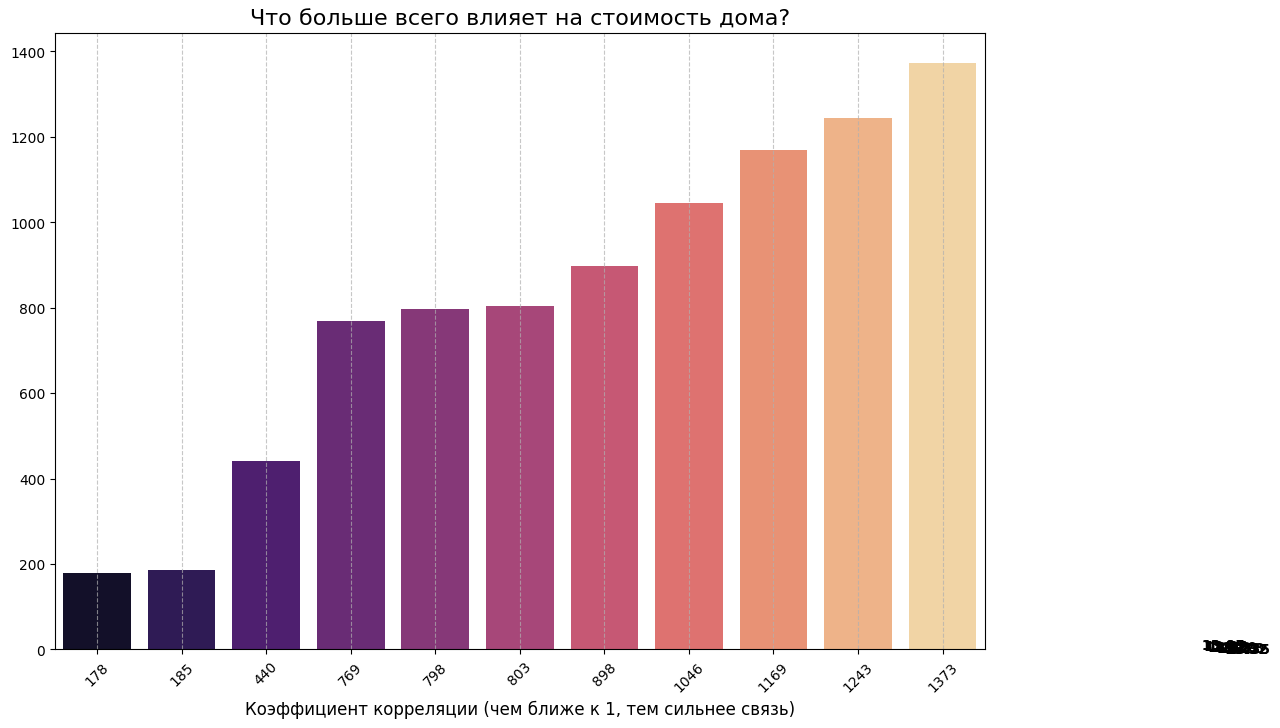

In [32]:
labels_map = {
    'SalePrice': 'Цена продажи',
    'OverallQual': 'Общее качество материалов',
    'GrLivArea': 'Жилая площадь (над землей)',
    'GarageCars': 'Вместимость гаража (авто)',
    'GarageArea': 'Площадь гаража',
    'TotalBsmtSF': 'Общая площадь подвала',
    '1stFlrSF': 'Площадь 1-го этажа',
    'FullBath': 'Полноценные ванные комнаты',
    'TotRmsAbvGrd': 'Всего комнат (без ванных)',
    'YearBuilt': 'Год постройки',
    'YearRemodAdd': 'Год реконструкции',
    'MasVnrArea': 'Площадь облицовки'
}

# 1. Получаем топ-10 корреляций
top_corr = df_num['SalePrice'].sort_values(ascending=False).head(11)

# 2. Создаем названия для графика (если названия нет в словаре, оставим как есть)
nice_labels = [labels_map.get(col, col) for col in top_corr.index]

labels_dict = {'OverallQual': 'Качество', 'GrLivArea': 'Пл. Жилая', 'GarageCars': 'Гараж (мест)'}
current_names = top_corr.index
new_names = [labels_dict.get(col, col) for col in current_names]

# 3. Строим красивый график
plt.figure(figsize=(12, 8))
sns.barplot(x=new_names, y=nice_labels, palette='magma')

# Добавляем подписи значений прямо на столбцы для наглядности
for i, v in enumerate(top_corr.values):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontweight='bold')

plt.title('Что больше всего влияет на стоимость дома?', fontsize=16)
plt.xlabel('Коэффициент корреляции (чем ближе к 1, тем сильнее связь)', fontsize=12,)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

##  Проводим анализ категориальных данных

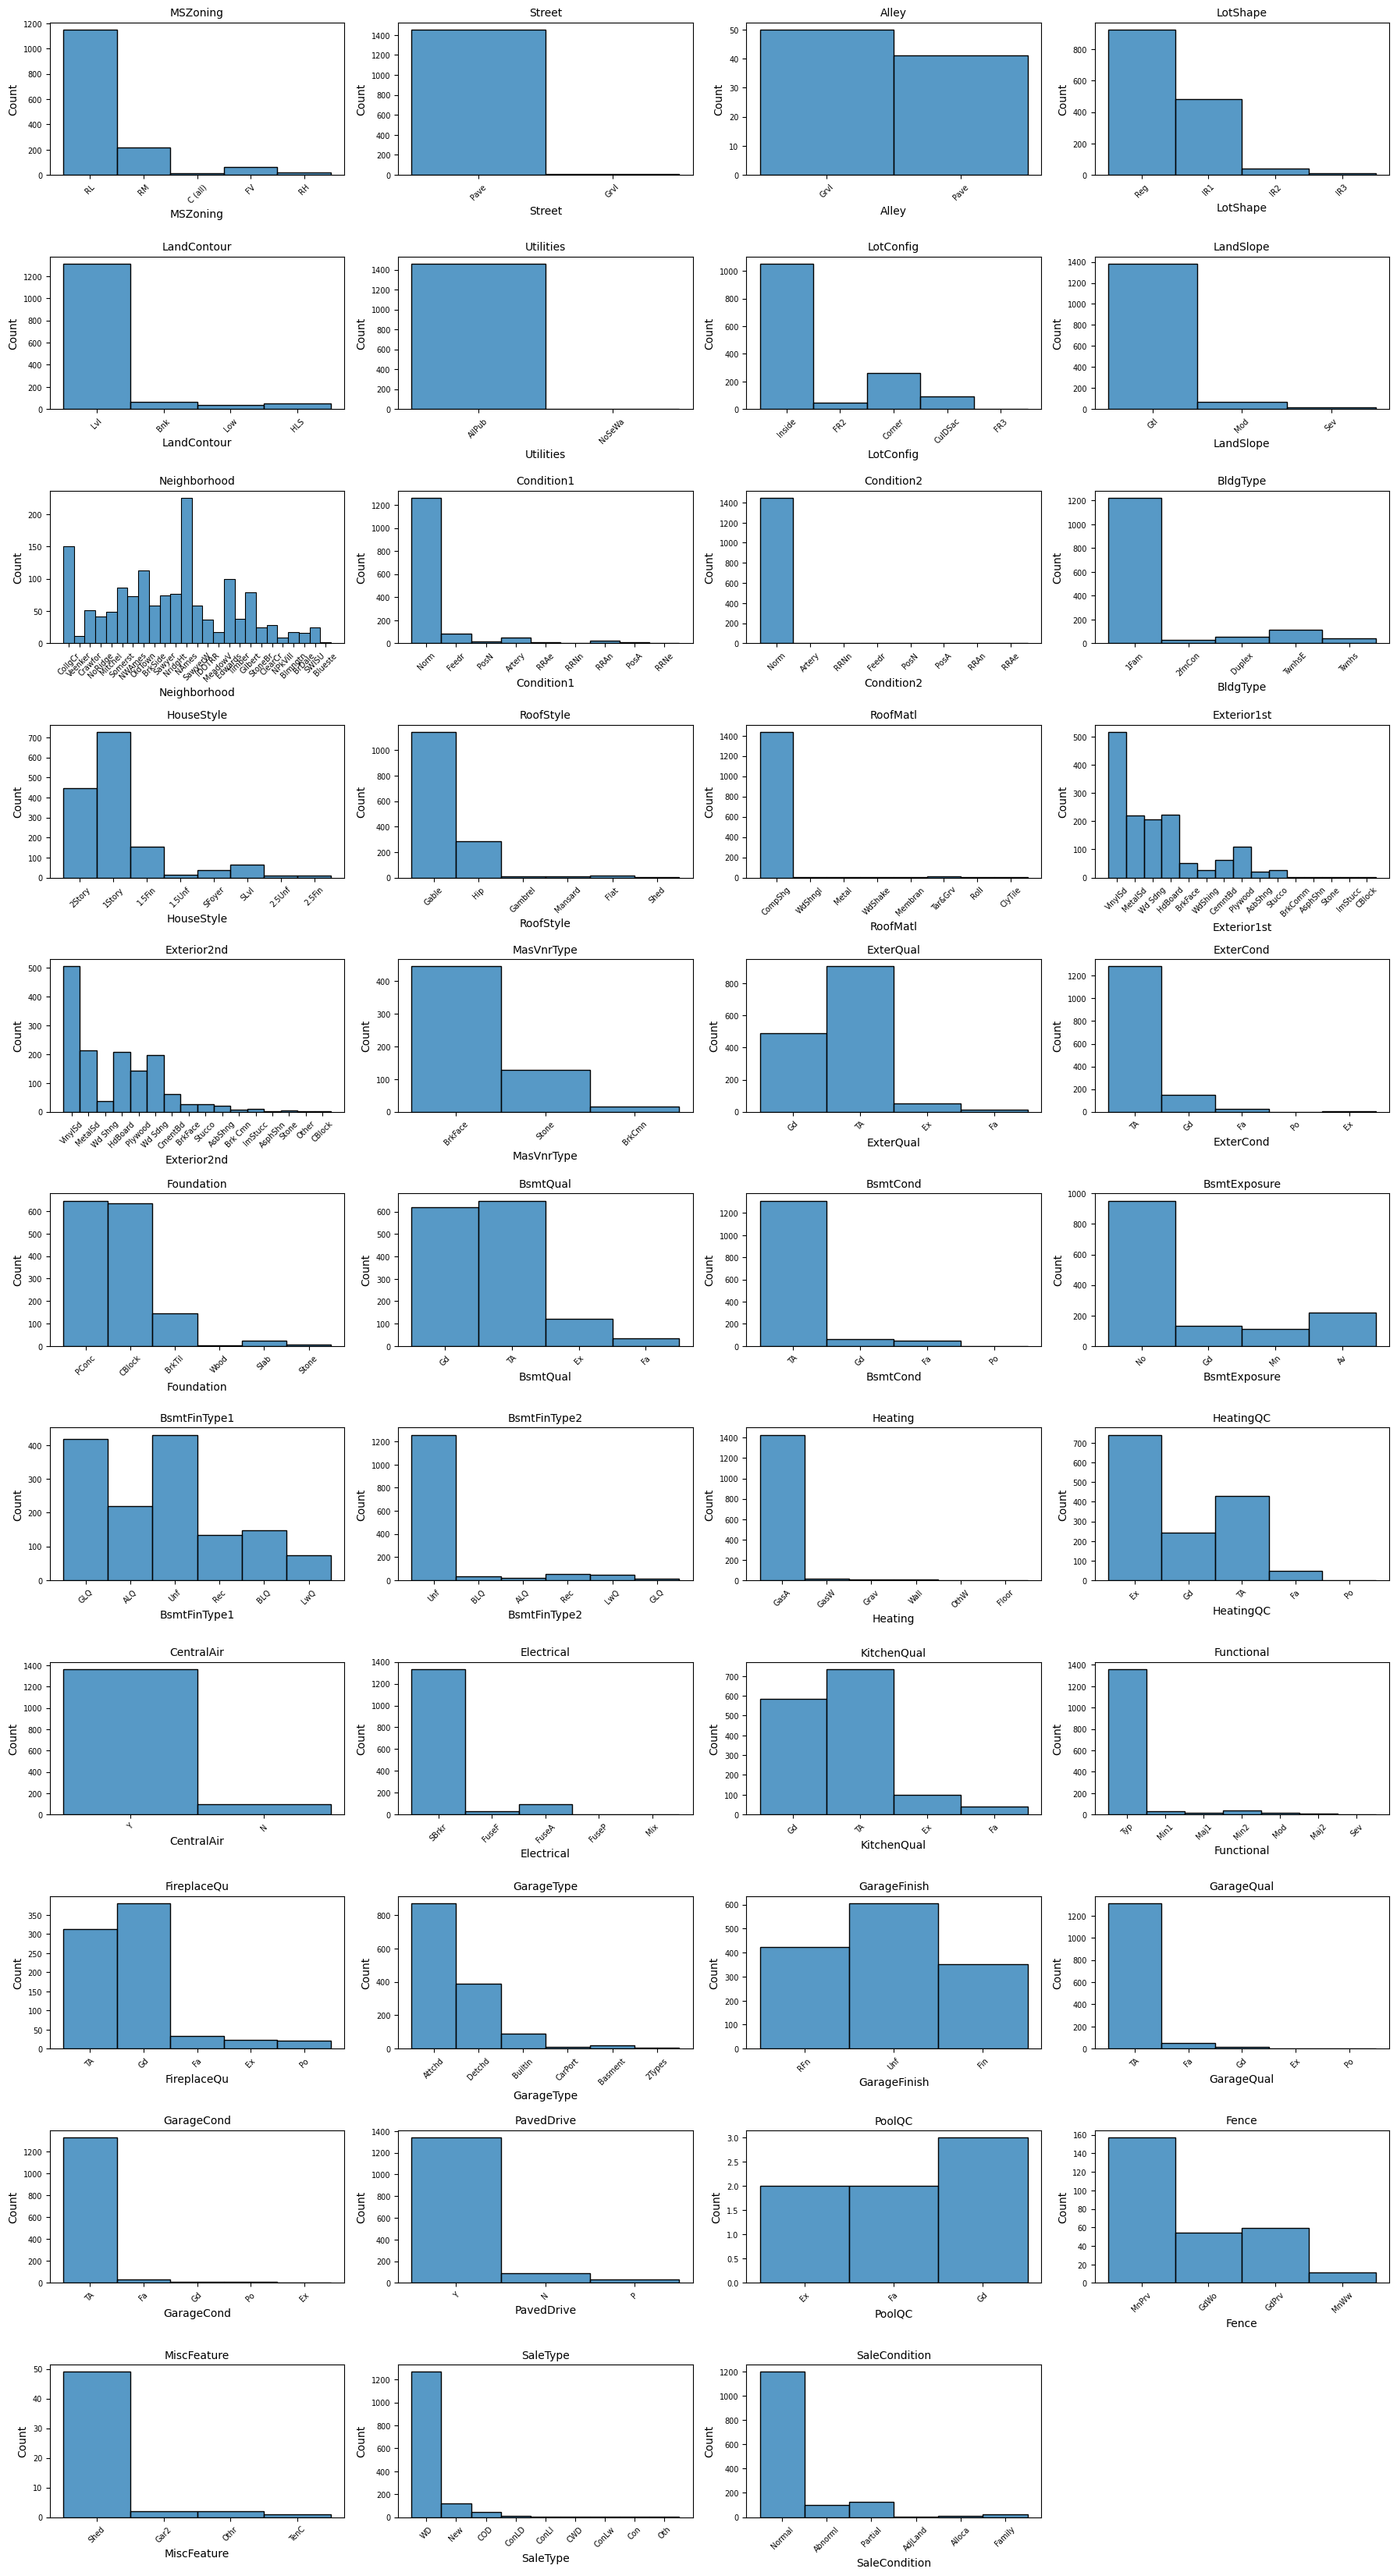

In [33]:
# Строим графики по категориальным данным
n_cols = 4
cat_features = len(df_cat)
n_rows = (cat_features + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_cat):
    sns.histplot(x=train[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Предварительный анализ категориальных признаков

MSZoning. Доминирует жилая застройка низкой плотности, дальше идет жилая застройка средней плотности, остальные редкие. Тип зонирования представлен неравномерно, но признак может быть полезный

Street. Преимущественно везде асфальт, гравия почти нет. Поскольку преобладвет один тип, вероятнее всего эта категория не несёт информации. 

Alley. На графике две категории гравий и асфальт. Однако так же содержится много пропусков, однако эти Nan зозначают отсутствие доступа к переулку. Необходимо заполнить отдельной категорией “NoAlley”.

LotShape. Сильно доминирует нормальная форма участка, далее идет слегка заметная, остальные редкие. Значит форма участка влияет, но редкие категории могут дать шум. 

LandContour. Почти весь рельеф участка ровный, остальные сильно меньше. Значит “рельеф участка” обычно одинаковый, но редкие значения могут быть информативны. 

Utilities. На графике мы видим, что почти все публичные комуникации доступны. Значит почти константа, возможно надо будет удалить.

LotConfig. Идим разные конфигурации участка, преимущественно внутренний и угловой, где внутренний доминирует, остальные встречаются реже. Значит “конфигурация участка” может влиять на стоимость.

LandSlope. Уклон участка преимущественно один: легкий. Значит почти константа, возможно надо будет удалить.

Neighborhood. Много категорий, распределение неоднородное. Возможно это один из самых сильных факторов. 

Condition1/Condition2. Близость к объектам почти везде нормальная, остальные редкие (Feedr, Artery и т.п.). Значит “соседство с дорогой/жд” может оказывать влияние.

BldgType. Отдельные дома доминирует, остальные представленны меньше. Значит тип здания влияет.

HouseStyle. Одноэтажные и двухэтажные дома доминируют, остальные встречаются реже. Значит стиль/этажность важны. 

RoofStyle. Амбарный стиль крыши доминирует, вальмовые крыши так же имеют заметный вес, прочие редкие.

RoofMatl. Практически константа, видим только композиционную черепицу. Возможно необходимо удалить.

Exterior1st/Exterior2nd. Несколько крупных категорий и хвост редких. Значит материал фасада важен.

MasVnrType. Доминирует облицовочный кирпич, остальные редкие. Однако у нас 60% пропущенных значений. Значение пропусков вероятнее "нет отделки" необходимо заполнить отдельной категорией.

ExterQual/ExterCond. В категориях качества видно, что 'среднее' и 'хорошее' преобладают. Это порядковая шкала, которую необходимо закодировать.

Foundation. Нормальное распределение нескольких категорий, оставляем и кодируем.

BsmtQual. На графике видно распределение по высоте подвала, NA(2,5%) означает “нет подвала”. 

BsmtCond. Состояние подвала, почти всё "типичное"; плюс NA(2,5%) обработаем как отсутствие подвала.

BsmtExposure. Окна у подвалов отсутствуют. Пропуски обработаем по аналогии выше.

BsmtFinType1. Тип отделки подвала преимущественно 'хороший' и 'незаконченный'. Пропуски обработаем по аналогии выше.

BsmtFinType2. Второй тип отделки — почти всегда 'незаконченный', остальные редкие. Почти константа, возможно стоит объединить или удалить.

Heating. Почти всё газ. Опять-таки константа, вороятнее нужно будет удалить.

HeatingQC. 5 разных качеств отопления оаспределены по всему графику. 

CentralAir. Практически везде наличие центрального кондиционера. Необходим дальнейший анализ оставлять ли данную категорию.

Electrical. В электросистемах преобладают 'автоматы'. Возможно стоит оставить ли категории, а остальные объединить.

KitchenQual. На графике видно 4 разных вида качества кухни, возможно есть взаимосвязь со стоимостью.

Functional. Преобладает типичная функциональность, остальные редкие. Можно объединить всё в “Other”.

FireplaceQu. в категории 'качество камина' у нас 47% NA, которые интерпретируются как 'нет камина'. Видно две крупные категории и хвост. 

GarageType. Из нескольких видов гаражей преобладают 'соединен с домом' и 'отдельно от дома'. Значения NA означают отсутствие гаража.

GarageFinish. Отделка гаража состоит из 'закончена', 'незакончена', 'черновая отделка'. Значения NA означают отсутствие гаража.

GarageQual/GarageCond. Качество/состояние гаража 'типичное'. Почти что константа.Значения NA означают отсутствие гаража.

PavedDrive. Часиная парковка почти всё 'да'. Посмотреть корреляцию и в зависимости от результата, возможно удалить.

PoolQC. В графике видно несколько столбиков, однако там почти все NA, что означет 'отсутствие бассейна'.

Fence. Мало показательных наблюдений, NA означает “нет забора”. Д.

MiscFeature. В прочих объектах большую долю составляют NA/None, немного Shed. Необходимо переквалифицировать NA в 'отсутствие'.

SaleType. Доминирует'договор купли продажи', так же заметны новые дома, остальные редкие. Возможно редкие стоит объединить в “Other”.

SaleCondition. В условиях сделки преобладают: 'типичные'. 

In [34]:
# смотретрим корреляцию категориальных данных с ценой

cat_columns = df_cat.columns

# One-Hot
dummies = pd.get_dummies(df_cat, drop_first=False)

# Берём корреляцию по логарифму таргета (так точнее)
corr_cat = dummies.apply(lambda x: x.corr(train['SalePrice']))

# Сортируем
corr_cat.sort_values(ascending=False).head(10)

BsmtQual_Ex             0.553105
KitchenQual_Ex          0.504094
Foundation_PConc        0.497734
ExterQual_Gd            0.452466
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
Neighborhood_NridgHt    0.402149
SaleType_New            0.357509
dtype: float64

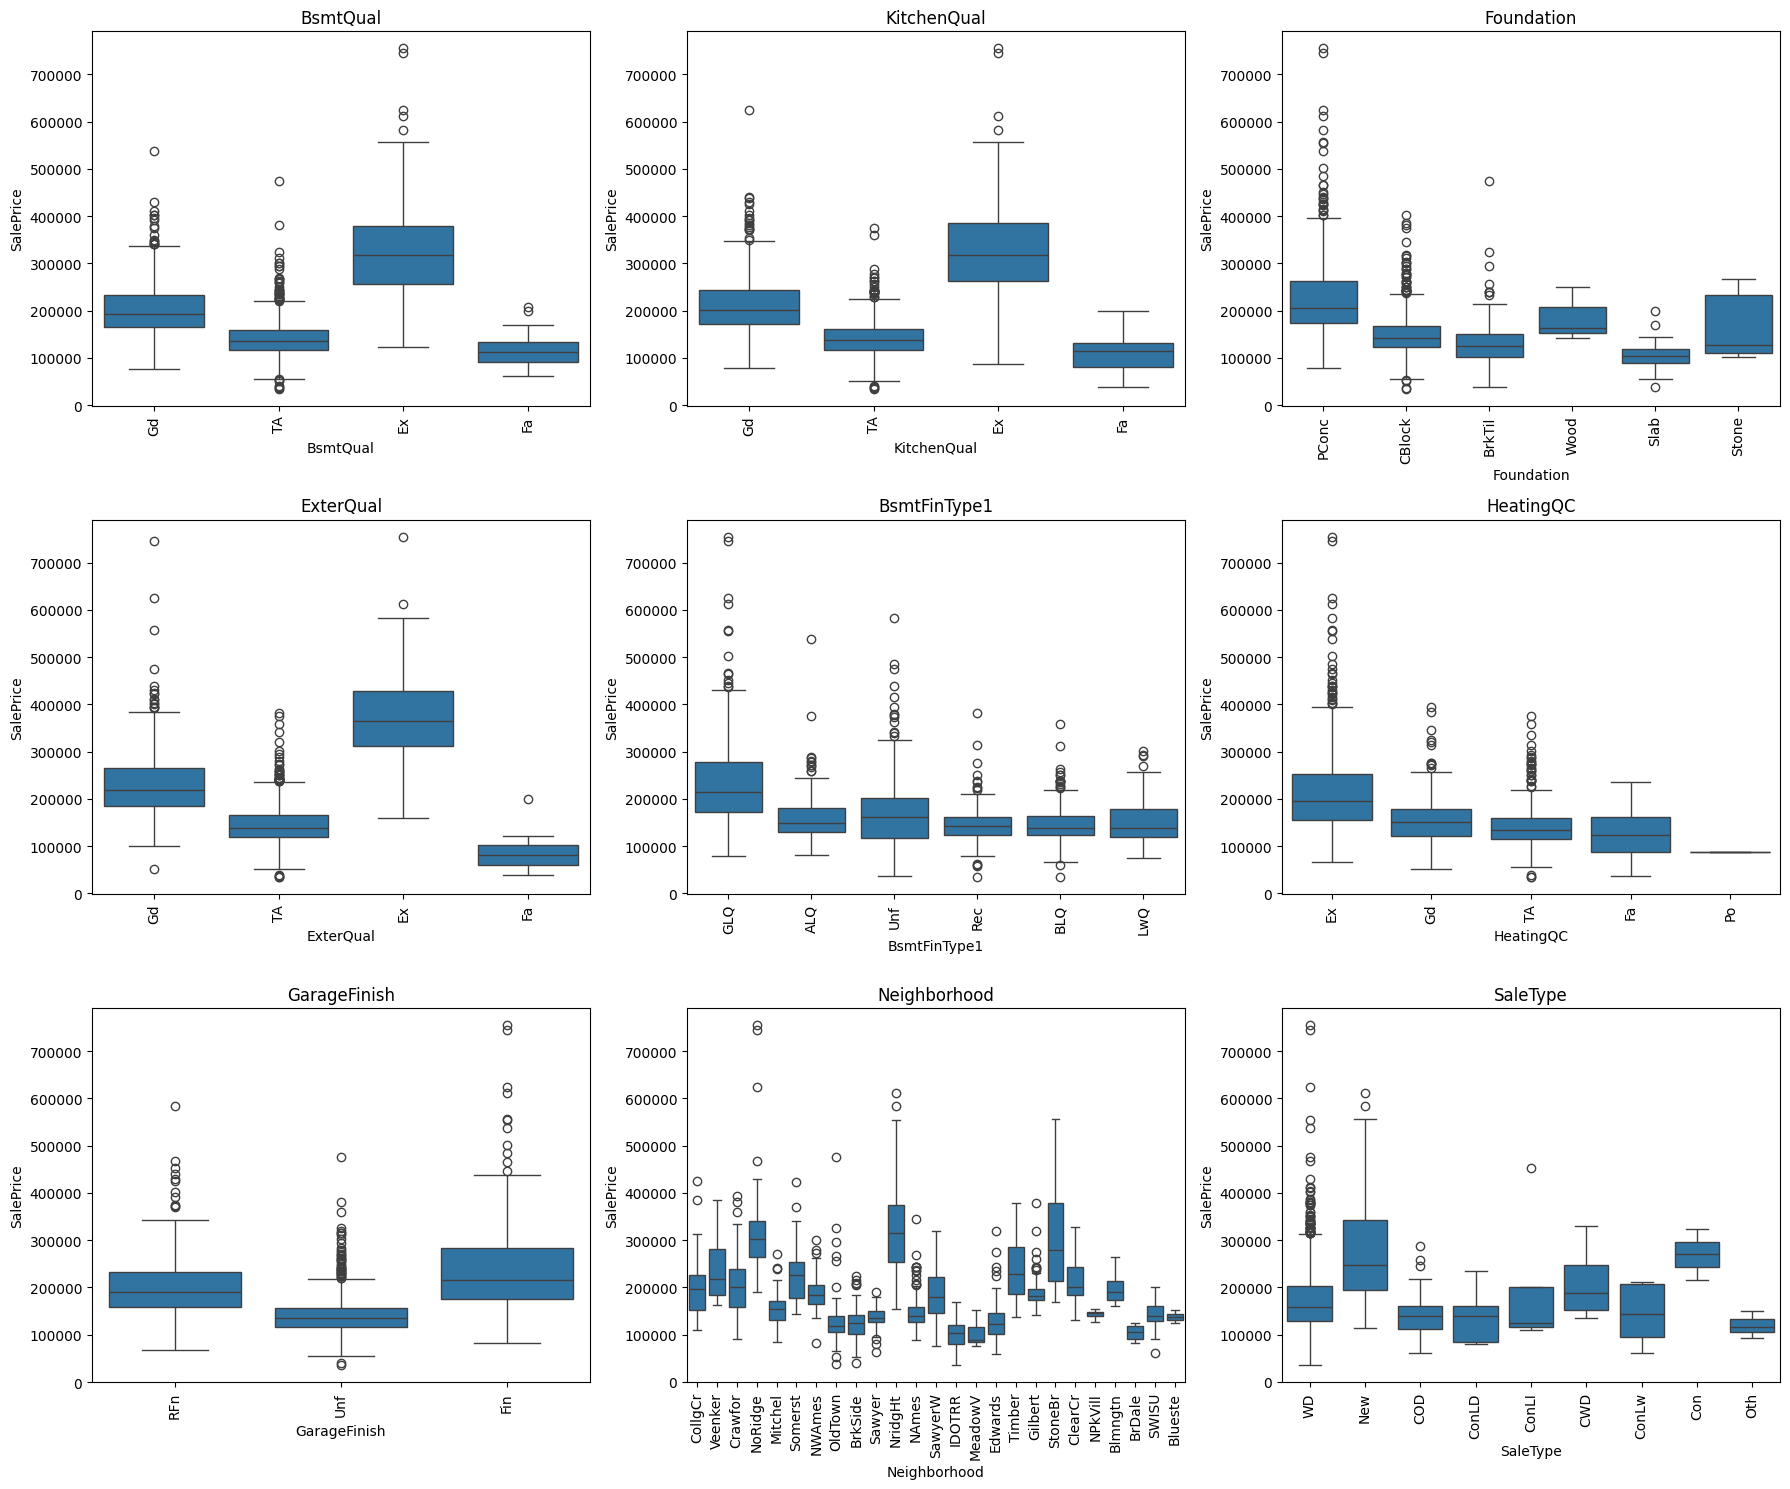

In [35]:
cols = ["BsmtQual", "KitchenQual", "Foundation", "ExterQual",  
        "BsmtFinType1" , "HeatingQC", "GarageFinish", "Neighborhood", "SaleType"
        ]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=train[col], y=train["SalePrice"], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Некоторые категориальные признаки содержат сильное влияние на стоимость жилья. В любом признаке, где значения отражают качество  есть рост цены
Особенно выделяются:
качество отделки + район + состояние гаража/подвала.

Создаем колонки, необходимые для заполнения пропусков

In [77]:
# Категориальные признаки, где NaN означает отсутствие объекта:
columns_none = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType",
    "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature", "MasVnrType"]

# Категориальные признаки, где NaN означает ошибку (надо заполнять mode)
columns_cat_fill = ["MSZoning", "Exterior1st", "Exterior2nd", "KitchenQual",
    "SaleType", "Electrical", "Functional", "Utilities"
]

# Все категориальные признаки из датафрейма
all_cat_cols = dataset_df.select_dtypes(include='object').columns.tolist()

other_cat_cols = [c for c in all_cat_cols if c not in set(columns_none + columns_cat_fill)]



In [78]:
# колонки, которые должны быть числовыми
fix_cols = ["MSSubClass", "OverallQual", "OverallCond"]

for c in fix_cols:
    train[c] = pd.to_numeric(train[c], errors='coerce')
    test[c] = pd.to_numeric(test[c], errors='coerce')


In [79]:
# Заполняем LotFrontage медианой внутри Neighborhood
for dataset in [train, test]:
    dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Пропуски в GarageYrBlt, если гаража нет → ставим год постройки дома
for dataset in [train, test]:
    dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["YearBuilt"])

# Пропуски в HasGarage определены, поэтому превращаем в число
for dataset in [train, test]:
    dataset["HasGarage"] = (dataset["GarageType"] != "None").astype(int)

# Отсутствие каменной заполняем 0.
for dataset in [train, test]:
    dataset["MasVnrArea"] = dataset["MasVnrArea"].fillna(0)

In [80]:
# Удаляем выбросы
train = train[train["GrLivArea"] < 4000].copy()

In [81]:
# Логарифмируем таргет
train["SalePrice_log"] = np.log1p(train["SalePrice"])
y = train["SalePrice_log"]

In [82]:
for c in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[c] = train[c].replace("None", np.nan)
    test[c] = test[c].replace("None", np.nan)

In [83]:
#  Собираем препроцессинг
cat_none = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

cat_mode = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

cat_other = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_none", cat_none, columns_none),
        ("cat_mode", cat_mode, columns_cat_fill),
        ("cat_other", cat_other, other_cat_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

In [84]:
# Делим на train/valid
X = train.drop(["SalePrice", "SalePrice_log"], axis=1)
X_test = test.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Пайплайн модели
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("random_forest", RandomForestRegressor(n_estimators=300))
])

In [86]:
# Применяем только препроцессор (без модели)
X_train_transformed = preprocessor.fit_transform(X_train)

# Превращаем в DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed)

# Проверяем наличие NaN
X_train_transformed_df.isna().sum().sum()


np.int64(0)

In [87]:
# Обучение
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_none',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Alley', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'FireplaceQu', 'GarageType'...
                                                                                 sparse_output=False))]),
                                                  ['Street', 'LotShape',
                                                   'LandContour', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'PavedDrive',
                                                   'SaleCondition'])],
                                   verbose_feature_names_out=False)),
                ('random_forest', RandomForestRegressor(n_estimators=300))])

In [88]:
# Предсказания на тесте и обратный откат
test_pred_log = pipe.predict(X_test)
test_pred = np.expm1(test_pred_log)

In [89]:
#  Формируем submission.csv
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": test_pred
})

submission.to_csv("my_submission.csv", index=False)